#Examples showing how to create and manipulate boundaries

In [1]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt
from pyvm.models.vm import VM

Populating the interactive namespace from numpy and matplotlib


## Dipping boundaries

Initialize a model, add dipping boundaries, and fill layers with constant velocities:

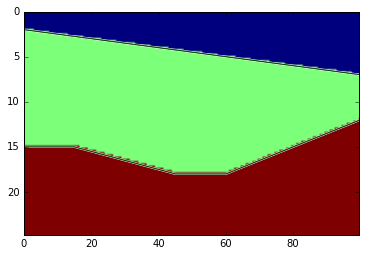

In [3]:
# define the model domain in terms of grid dimensions, spacing, and origin
vm = VM(shape=(200, 1, 100), spacing=(0.5, 1, 0.25), origin=(0, 0, 0))

# add a sloping boundary
z = np.reshape(2 + 0.05*(vm.grid.x),(vm.nx,1))
vm.insert_interface(z)

# piecewise defined boundary
specs = [#xstart, xend, slope
    [0., 15., 0.],
    [15., 45., 0.1],
    [45., 60., 0.],
    [60., vm.r2[0], -0.15]]

z0 = 15.  # intial depth at left-hand side of model

# build full boundary
z = np.ones(vm.nx)
for x0, x1, m in specs:
    ix = vm.xrange2i(x0, x1)
    x = vm.grid.x[ix]
    z[ix] = z0 + m * (x - x[0])
    
    z0 = z[ix[-1]]

# add the boundary
vm.insert_interface(np.reshape(z, (vm.nx, 1)))

# add some velocities
vm.define_constant_layer_velocity(0, 1.5)
vm.define_constant_layer_velocity(1, 2.5)
vm.define_constant_layer_velocity(2, 3.5)

# plot
vm.plot()

## Modifying existing boundaries

Add a cosine perturbation to the first boundary:

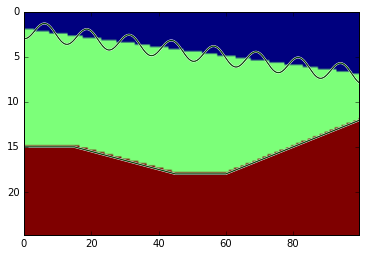

In [7]:
vm.rf[0] += np.cos(0.5 * vm.grid.x).reshape((vm.nx, 1))

vm.plot()

Note that boundary has changed, but the velocity grid has not.  We can update the velocity grid with:

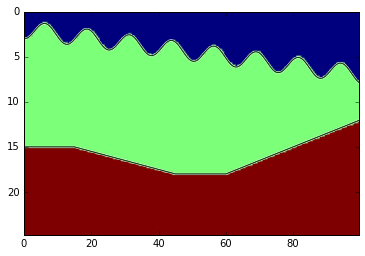

In [8]:
vm.define_constant_layer_velocity(0, 1.5)
vm.define_constant_layer_velocity(1, 2.5)

vm.plot()